# Dimensionality reduction: tutorial
Let's do some practical exercises with what we have learnt
## Data generation 
We wish to generate synthetic 2D and 3D data to play with. 

Please carefully read the code we provide for you, make sure to understand what is happening here. 

In [1]:
import numpy as np
np.random.seed(743359) # random seed for consistency
from numpy.random import multivariate_normal as MVN
import matplotlib.pyplot as pl
import matplotlib.pyplot as plt
import sklearn

In [2]:
# draws from standard normal
def gen_gauss_prior(D=1, N=50):
    zero_mean = np.zeros(D)
    identity_cov = np.eye(D)
    z = MVN(zero_mean, identity_cov, N)
    return z

In [3]:
# generates Gaussian observations data set 
def gen_gauss_obs(W, mu, zs, sigma):
    """Sample a dataset from p(x|z)."""
    
    N, D, M = len(zs), len(mu), zs.shape[1]
    W, mu = np.asarray(W), np.asarray(mu)
    print('{} {}-dim observations from {}-dim latents'.format(N, D, M))

    xs = np.array([MVN(W@z + mu, sigma*np.eye(D)) for z in zs])
    return xs

In [4]:
# sample latents from a MVN (here one-dimensional)
zs = gen_gauss_prior(D=1, N=60)

In [7]:
# generate samples from 2D Gaussian with 1D latents 
xs = gen_gauss_obs(W=[[1],[1]], mu=[3,1], zs=zs, sigma=0.1)

60 2-dim observations from 1-dim latents


In [14]:
np.shape(xs)

(60, 2)

In [8]:
# calculate the mean along first dimensions 
xsmean = xs.mean(axis=0, keepdims=True)

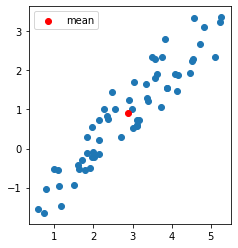

In [9]:
# plot data as scatter, plot mean
ax = pl.subplot(111, label='by hand')
ax.scatter(*xs.T) # short for unpack to xs[:,0], xs[:,1]
ax.scatter(*xsmean.T, color='r', label='mean')
ax.set_aspect('equal')
plt.legend()
pl.show()

## Observe the plot above: 

do you recognize the latent structure which is only 1D (plus a bit of noise (sigma=0.1))? 

TODO: explain what you see and why
The latent structure is a Gaussian centered at (3,1) + noise that is over the line determined by the vector  W=(1,1)

# PCA 'by hand'
Note we actually rely on the primitives `np.cov` and `np.eigval`

In [20]:
# TODO: calculate covariance matrix of the data
S = np.cov(xs.T)

In [21]:
np.shape(S)

(2, 2)

In [24]:
# TODO: compute eigenvectors and values
ls, vs = np.linalg.eig(S)

In [ ]:
# TODO: check whether eigenvector are correct: what is the result of applying S to vs? What should it be? 
# if confused, check the definition of eigenvectors of a matrix. 
# note eigenvalues laid out in columns


In [ ]:
# optional: check correct, using similarity relation S - \Lambda

In [ ]:
# TODO: sort eigenvectors by eigenvalues


## Plot the Transformed data
Project data on eigenvector and plot it. 

# PCA with sklearn

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
transform = pca.fit_transform(xs)

In [ ]:
PCA

In [ ]:
def ziptr(*args): 
    return list(zip(*args))
# print each eigenvalue with its eigenvector
es_by_sklearn= ziptr(pca.explained_variance_, pca.components_)

In [ ]:
es_by_hand

In [ ]:
# see StackOverflow question 44765682 for sign ambiguity
es_by_sklearn

In [ ]:
pl.scatter(*zip(*(-transform)))
pl.scatter(*zs)
pl.axis('equal')
pl.show()

Don't be surprised if the plot is the mirror image of the plot of the PCA by hand - there's ambiguity in the sign of the eigenvectors, since both signs indicate the same direction for the subspace. We can simply multiply the transformed data by (−1) to revert the mirror image.

MNIST PCA
further reference: [colah notebook](https://colah.github.io/posts/2014-10-Visualizing-MNIST) 

# Sphering with PCA
Typical pre-processing step: normalize data to have zero mean and unit variance.

With PCA one can add decorrelation of features - i.e. rewrite features in t®ms of orthogonal basis vectors.

This is a dataset rotation, i.e. no dimensionality reduction, $M=D$, into a basis in which its covariance matrix is diagonal.

Task: 

1. generate a dataset. 
2. center and rotate (decorrelate features) by applying $$y_n = U^\top (x_n - \bar{x})$$
3. Rescale projected values to have unit variance: $$\tilde{y}_n = \Lambda^{-1/2} U^\top (x_n-\bar{x})$$
4. How to do this when using sklearn?

# PCA for compression: faces
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html


Load the olivetti faces dataset from sklearn: 400 images each of which has $64^2$ pixels

In [ ]:
from sklearn import datasets
faces = datasets.fetch_olivetti_faces()
faces.data.shape

Visualize the data we're working with - note faces have been localized and scaled to a common size.

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone)
pl.show()

Reduce the thousands of features to just 150

In [ ]:
efaces = PCA(n_components=150, whiten=True)
efaces.fit(faces.data)

In [ ]:
print(efaces.components_.shape)
fig = pl.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(efaces.components_[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
pl.show()

Notice how the components that explain the highest variance first tackle global illumination,and then progressively finer and finer features (eyebrows, eyes, lips...)

For subsequent use (i.e. classification) we can use not the original images ($64^2$ dimensions) but just the coefficients to these eigenfaces (150). These are given by

In [ ]:
facescores = efaces.transform(faces.data)
facescores.shape

# Showcase: probabilistic models can be cross-validated for the number of components

In [ ]:
# From the sklearn documentation
# Authors: Alexandre Gramfort
#          Denis A. Engemann
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

print(__doc__)

# #############################################################################
# Create the data

n_samples, n_features, rank = 1000, 50, 10
sigma = 1.
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

# #############################################################################
# Fit the models

n_components = np.arange(0, n_features, 5)  # options for n_components


def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X, cv=5)))
        fa_scores.append(np.mean(cross_val_score(fa, X, cv=5)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages}, cv=5)
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X, cv=5))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X, cv=5))


for X, title in [(X_homo, 'Homoscedastic Noise'),
                 (X_hetero, 'Heteroscedastic Noise')]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver='full', n_components='mle')
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
    plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa,
                linestyle='--')
    plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet',
                label='Shrunk Covariance MLE', linestyle='-.')
    plt.axhline(lw_score(X), color='orange',
                label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title(title)

plt.show()

# Cancer


In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
# print(cancer.DESCR)

D = 30  (smoothness, radius etc.) N=569, 212 are malignant (encoded 0) and 357 benign (encoded 1).

Plot axis aligned histograms...

In [ ]:
cancer.data.shape

In [ ]:
N, D = cancer.data.shape
fig, axes = pl.subplots(10, 3, figsize=(12, 9)) 
malignant = cancer.data[cancer.target==0] 
benign = cancer.data[cancer.target==1]
ax = axes.ravel()# flatten axes for iteration
for i, name in enumerate(cancer.feature_names):
  _, bins = np.histogram(cancer.data[:,i], bins=40)
  ax[i].hist(malignant[:,i], bins=bins, color='r', alpha=.5)
  ax[i].hist(benign[:,i], bins=bins, color='g', alpha=0.3)
  ax[i].set_title(name,fontsize=9)
  ax[i].axes.get_xaxis().set_visible(False)
  ax[i].set_yticks(())
ax[0].legend(['malignant','benign'], loc='best', fontsize=8)
plt.tight_layout()
plt.show()

Some features have a great classification potential, others not so much. Worse, some are semi-redundant:

In [ ]:
import pandas as pd
cancer_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
pl.subplot(1,2,1)
pl.scatter(cancer_df['worst symmetry'], cancer_df['worst texture'], s=cancer_df['worst area']*0.05, color='magenta', label='check', alpha=0.3)
pl.xlabel('Worst Symmetry',fontsize=12)
pl.ylabel('Worst Texture',fontsize=12)
pl.subplot(1,2,2)
pl.scatter(cancer_df['mean radius'], cancer_df['mean concave points'], s=cancer_df['mean area']*0.05, color='purple', label='check', alpha=0.3)
pl.xlabel('Mean Radius',fontsize=12)
pl.ylabel('Mean Concave Points',fontsize=12)
pl.show()

In [ ]:
fig, axes = pl.subplots(1, 2, figsize=(12, 9)) 
cancer_df.plot.scatter(x='worst symmetry', y='worst texture', ax=axes[0])
cancer_df.plot.scatter(x='mean radius', y='mean concave points', ax=axes[1])
pl.tight_layout()
pl.show()

In [ ]:
# industrialize
from pandas.plotting import scatter_matrix
scatter_matrix(cancer_df.iloc[:, 0:30:7], 
               c=cancer.target, marker='.', alpha=0.8)
pl.show()

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(cancer.data)
cancer_pca = PCA(n_components=3) 
z_cancer = cancer_pca.fit_transform(X_scaled)
z_cancer.shape

In [ ]:
colors = dict(enumerate(['red', 'green']))
labels = dict(enumerate(['Malignant', 'Benign']))
marker = dict(enumerate(['*', 'o']))
alpha = dict(enumerate([.3, .5]))
fig,ax = pl.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
zx, zy = z_cancer[:,0], z_cancer[:,1]
for t in np.unique(cancer.target):
    ix = np.where(cancer.target==t)
    ax.scatter(zx[ix],zy[ix],c=colors[t],s=40,
               label=labels[t],marker=marker[t],alpha=alpha[t])
pl.xlabel("First Principal Component",fontsize=14)
pl.ylabel("Second Principal Component",fontsize=14)
pl.legend()
pl.show()

In [ ]:
# heat plot for mixing
pl.matshow(cancer_pca.components_,cmap='viridis')
pl.yticks([0,1,2],['1st Comp','2nd Comp','3rd Comp'],
          fontsize=10)
pl.colorbar()
pl.xticks(range(len(cancer.feature_names)),
          cancer.feature_names, rotation=65, ha='left')
pl.tight_layout()
pl.show()

In [ ]:
# worst features
feature_worst=list(cancer_df.columns[20:31]) 
import seaborn as sns
s=sns.heatmap(cancer_df[feature_worst].corr(),cmap='coolwarm') 
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7)
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7)
plt.show()

# PCA for vis, denoising: handwritten digits
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

# PCA for understandings; cancer dataset
https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21
# PCA for preprocessing - importance downstream of feature scaling
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html

# References
* https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21
* https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html